In [21]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline  

In [22]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

In [23]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data

In [24]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

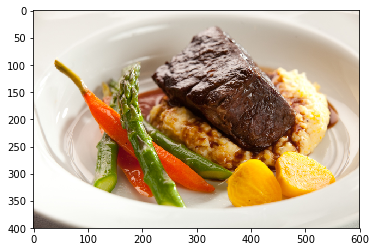

In [32]:
im = cv2.imread("entree-1.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

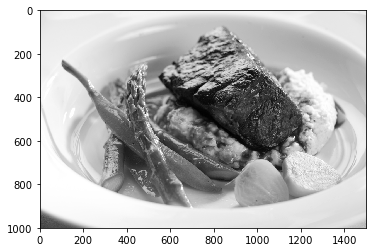

980
36


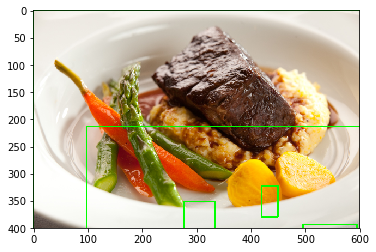

In [34]:
imgray = cv2.imread("entree-1.jpg", 0)
plt.imshow(imgray, cmap='gray')
plt.show()

flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )

im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

copy = im.copy()
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

In [ ]:
def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0. The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

In [ ]:
pimage, mask = preprocess(im,  [0,0, 0], [255, 255, 255])
plt.imshow(pimage)
plt.show()

In [ ]:
# detect people in the image
(rects, weights) = hog.detectMultiScale(im, winStride=(8, 8),
                                        padding=(16, 16), scale=1.05)

print(rects)
 
# draw the original bounding boxes
for (x, y, w, h) in rects:
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
 
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()